In [1]:
from datetime import datetime

import librosa.display
from dotenv import load_dotenv
import os
import librosa
import numpy as np
from sklearn.model_selection import train_test_split
import random

# 1. 資料加載與標記

In [2]:
def load_segmented_files(directory):
    wav_files = []
    leak_wav_files = []
    for dir in os.listdir(directory):
        if not os.path.isdir(os.path.join(directory, dir)):
            continue
        for file in os.listdir(os.path.join(directory, dir)):
            if not file.endswith(".wav"):
                continue
            file_path = os.path.join(directory, dir, file)
            y, sr = librosa.load(file_path, sr=None)
            filename = f'{dir}_{file}'
            if 'no-leak' in dir:
                wav_files.append((y, sr, filename))
            else:
                leak_wav_files.append((y, sr, filename))
    print(f"共有 {len(wav_files)} 個 wav 檔案，其中 {len(leak_wav_files)} 個有泄漏，{len(wav_files) - len(leak_wav_files)} 個沒有泄漏")
    return wav_files, leak_wav_files 

# 比較數量，均衡資料
def shuffle_data(wav_files, leak_wav_files):
    wav_files = random.sample(wav_files, len(wav_files))
    leak_wav_files = random.sample(leak_wav_files, len(leak_wav_files))
    
    return wav_files, leak_wav_files


def create_dataset(directory, max_length=None):
    wav_files, leak_wav_files = load_segmented_files(directory)
    
    wav_files, leak_wav_files = shuffle_data(wav_files, leak_wav_files)
    
    # 將資料轉為 NumPy 格式
    X = []
    y = []
    
    for audio, sr, filename in wav_files:
        X.append((audio, sr))
        y.append(0)  # wav_files 標記為 0
    
    for audio, sr, filename in leak_wav_files:
        X.append((audio, sr))
        y.append(1)  # leak_wav_files 標記為 1
    
    return X, np.array(y)


# 2. 特徵提取與資料預處理

In [3]:
from data_preprocess import extract_features, extract_stft_features

def preprocess_data(X, desired_time=2.0, n_mels=128, n_fft=2048, hop_length=512):
    features = []
    for audio, sr in X:
        feature = extract_stft_features(audio, sr, desired_time=desired_time, n_fft=n_fft, hop_length=hop_length)
        features.append(feature)
    return np.array(features)


# 3. 建立 CNN 模型

In [4]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

def create_cnn_model(input_shape=(128, 128, 1)):
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(128, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Conv2D(64, (3, 3), activation='relu'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Dropout(0.3))
    
    model.add(Flatten())
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1, activation='sigmoid'))  # 二元分類使用 sigmoid 激活函數
    
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    return model


In [5]:
def create_training_data(desired_time=2.0, directory='training_data'):
    X, y = create_dataset(directory)
    
    print(f"總樣本數: {len(X)}")
    print(f"標籤分佈: {np.bincount(y)}")
    
    
    X_features = preprocess_data(X, desired_time=desired_time)
    
    print(f"特徵形狀: {X_features.shape}")  # 預期形狀: (樣本數, max_len, n_mels)
    
    # 正規化特徵
    X_features = (X_features - np.mean(X_features)) / np.std(X_features)
    
    # 擴展維度以符合 CNN 輸入 (樣本數, 高, 寬, 通道)
    X_features = np.expand_dims(X_features, -1)  # 新形狀: (樣本數, max_len, n_mels, 1)
    
    # 分割訓練集與測試集
    X_train, X_test, y_train, y_test = train_test_split(X_features, y, test_size=0.2, random_state=42)
    
    print(f"訓練集形狀: {X_train.shape}")
    print(f"測試集形狀: {X_test.shape}")
    
    return X_train, X_test, y_train, y_test

In [6]:
def create_model(mockup_input):    
    # 建立模型
    input_shape = (mockup_input.shape[1], mockup_input.shape[2], 1)
    model = create_cnn_model(input_shape)
    model.summary()
    return model

# 4. 訓練模型

In [7]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau


def train_model(model, X_train, X_test, y_train, y_test, epochs=30, batch_size=32):
        # 訓練模型
        
    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
        
    history = model.fit(   
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        shuffle=True,
        callbacks=[early_stopping],
        verbose=2
    )
    
    # 評估模型
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.2f}")
    
    return model, history

In [8]:
def evaluate_model(model, X_test, y_test):
    test_loss, test_accuracy = model.evaluate(X_test, y_test)
    print(f"Test loss: {test_loss:.4f}")
    print(f"Test accuracy: {test_accuracy:.2f}")

In [9]:
X_train, X_test, y_train, y_test = create_training_data(directory='training_data', desired_time=2.0)

共有 10641 個 wav 檔案，其中 2581 個有泄漏，8060 個沒有泄漏
總樣本數: 13222
標籤分佈: [10641  2581]


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 2 dimensions. The detected shape was (13222, 192) + inhomogeneous part.

In [10]:
cnn_model = create_model(X_train)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 190, 126, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 95, 63, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 95, 63, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 93, 61, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 46, 30, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 46, 30, 64)        0

In [11]:
model, history = train_model(cnn_model, X_train, X_test, y_train, y_test, epochs=60)

Epoch 1/60
331/331 - 12s - loss: 0.4161 - accuracy: 0.8276 - val_loss: 0.3473 - val_accuracy: 0.8752 - 12s/epoch - 37ms/step
Epoch 2/60
331/331 - 8s - loss: 0.3292 - accuracy: 0.8638 - val_loss: 0.3004 - val_accuracy: 0.8711 - 8s/epoch - 24ms/step
Epoch 3/60
331/331 - 8s - loss: 0.3066 - accuracy: 0.8788 - val_loss: 0.3187 - val_accuracy: 0.8703 - 8s/epoch - 24ms/step
Epoch 4/60
331/331 - 8s - loss: 0.3101 - accuracy: 0.8747 - val_loss: 0.3399 - val_accuracy: 0.8945 - 8s/epoch - 24ms/step
Epoch 5/60
331/331 - 8s - loss: 0.2956 - accuracy: 0.8799 - val_loss: 0.2768 - val_accuracy: 0.9017 - 8s/epoch - 23ms/step
Epoch 6/60
331/331 - 8s - loss: 0.2871 - accuracy: 0.8827 - val_loss: 0.2648 - val_accuracy: 0.8953 - 8s/epoch - 24ms/step
Epoch 7/60
331/331 - 8s - loss: 0.2757 - accuracy: 0.8887 - val_loss: 0.3302 - val_accuracy: 0.8548 - 8s/epoch - 24ms/step
Epoch 8/60
331/331 - 8s - loss: 0.2716 - accuracy: 0.8891 - val_loss: 0.2646 - val_accuracy: 0.8817 - 8s/epoch - 24ms/step
Epoch 9/60
331

In [12]:
evaluate_model(cnn_model, X_test, y_test)

83/83 [==============================] - 1s 7ms/step - loss: 0.2334 - accuracy: 0.9100
Test loss: 0.2334
Test accuracy: 0.91


In [13]:
date = datetime.now().strftime('%Y%m%d%H%M')
model.save(f'model_{date}.h5')
print(f"Model saved as model_{date}.h5")

Model saved as model_202411011443.h5


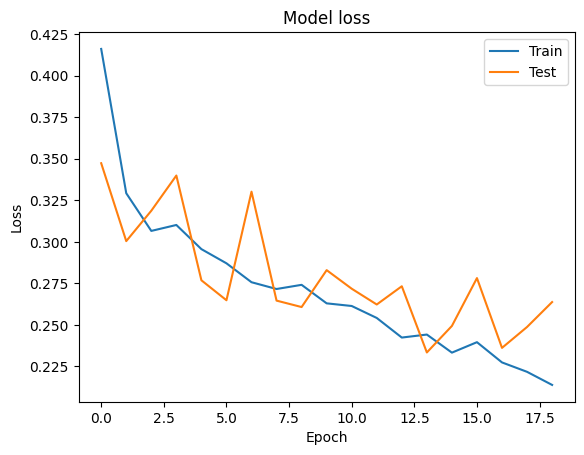

In [14]:
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper right')
plt.savefig(f'model_loss_{date}.png')
plt.show()